In [116]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

from io import StringIO
import warnings

import time
import random
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [85]:
def scrape_egressos(
    table_page: int,
    session_id="B0420027D05C88B682CD5257F5EE2B44",
    ingress_cookies="6329ec08d82118fb",
) -> pd.DataFrame:
    cookies = {
        "JSESSIONID": f"{session_id}",
        "INGRESSCOOKIE": f"{ingress_cookies}",
    }

    headers = {
        "Accept": "*/*",
        "Accept-Language": "pt-BR,pt;q=0.9",
        "Connection": "keep-alive",
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
        # 'Cookie': 'JSESSIONID=0BD6710C3A31B4AE55AE44CC488E77CE; INGRESSCOOKIE=6329ec08d82118fb',
        "Origin": "https://egressos.sistemas.ufsc.br",
        "Referer": "https://egressos.sistemas.ufsc.br/listaEgressos.xhtml",
        "Sec-Fetch-Dest": "empty",
        "Sec-Fetch-Mode": "cors",
        "Sec-Fetch-Site": "same-origin",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36",
        "sec-ch-ua": '"Google Chrome";v="129", "Not=A?Brand";v="8", "Chromium";v="129"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Windows"',
    }

    data = f"AJAXREQUEST=_viewRoot&j_id65%3Aj_id70=&j_id65%3Aj_id74=&j_id65%3Aj_id78=&j_id65%3AselectCursosGraduacao=0&j_id65=j_id65&autoScroll=&javax.faces.ViewState=j_id4&j_id65%3AformadosGraduacaoDataScroller={table_page}&AJAX%3AEVENTS_COUNT=1&"

    response = requests.post(
        "https://egressos.sistemas.ufsc.br/listaEgressos.xhtml",
        cookies=cookies,
        headers=headers,
        data=data,
    )

    soup = BeautifulSoup(response.text)
    tables = soup.find_all("table")
    result_table_str = str(tables[1])

    result_table = pd.read_html(StringIO(result_table_str))[0].drop(
        columns=["Unnamed: 0"]
    )

    return result_table

In [97]:
results_dict = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    for page in range(1, 1086):
        if page % 50 == 0:
            print("Sleeping for 5 seconds\n")
            time.sleep(5)

        if page % 100 == 0:
            print("Sleeping for 10 seconds and saving provisory file\n")
            provisory_df = pd.DataFrame(results_dict)
            provisory_df.to_csv(f"egressos_provisory_{page}.csv", index=False)
            time.sleep(25)

        print(f"Scraping page {page}\n")

        df = scrape_egressos(table_page=page)

        for column in df.columns:
            results_dict[column] = results_dict.get(column, []) + df[column].tolist()

        print(f"Page {page} scraped\n")
        clear_output(wait=True)
        time.sleep(1 * random.randint(1, 3))


Scraping page 1085

Page 1085 scraped



In [98]:
pd.DataFrame(results_dict).to_csv(f"egressos_provisory_{page}.csv", index=False)

In [99]:
df_grad = pd.DataFrame(results_dict)

In [109]:
df_grad["ano_ingresso"] = df_grad["Ano de Ingresso"].apply(lambda x: int(str(x)[:4]))
df_grad["ano_formatura"] = df_grad["Ano de Formatura"].apply(lambda x: int(str(x)[:4]))
df_grad["tempo_formatura"] = (
    df_grad["ano_formatura"] - df_grad["ano_ingresso"]
) + 1  # +1 para considerar o ano de ingresso

<Axes: xlabel='ano_formatura'>

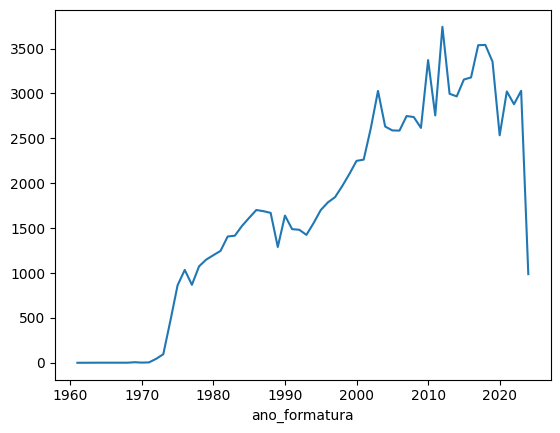

In [114]:
df_grad.value_counts("ano_formatura").sort_index().plot()

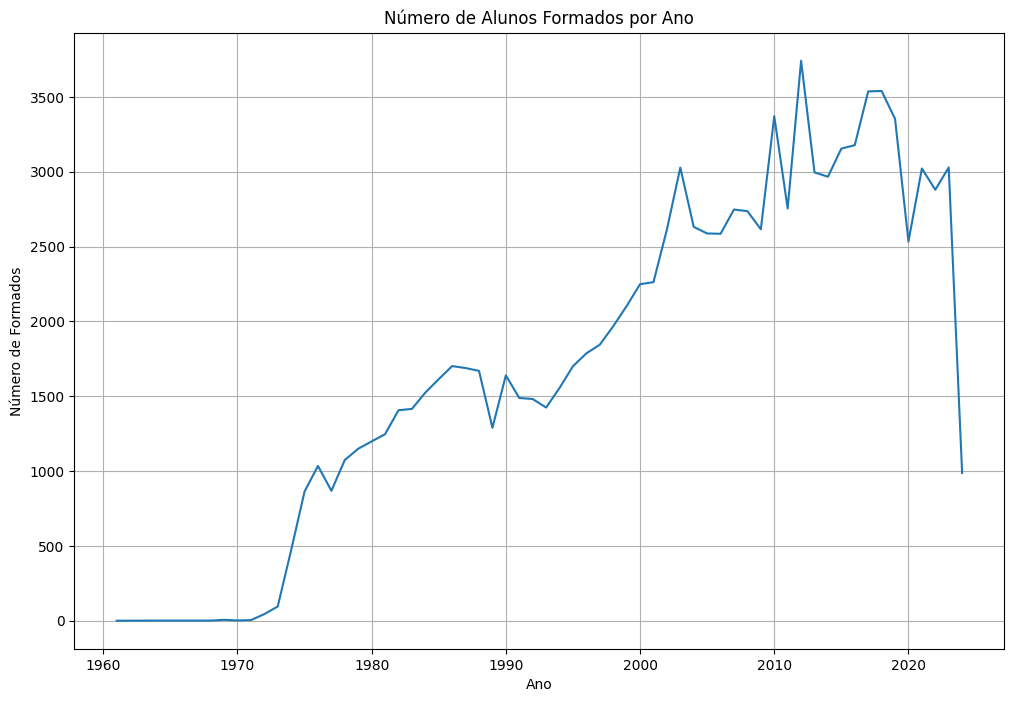

In [123]:
plt.figure(figsize=(12, 8))

anos = df_grad.value_counts("ano_formatura").sort_index().index.values
quantidade = df_grad.value_counts("ano_formatura").sort_index().values

plt.plot(anos, quantidade)

plt.xlabel("Ano")
plt.ylabel("Número de Formados")
plt.title("Número de Alunos Formados por Ano")
plt.grid()
plt.show()

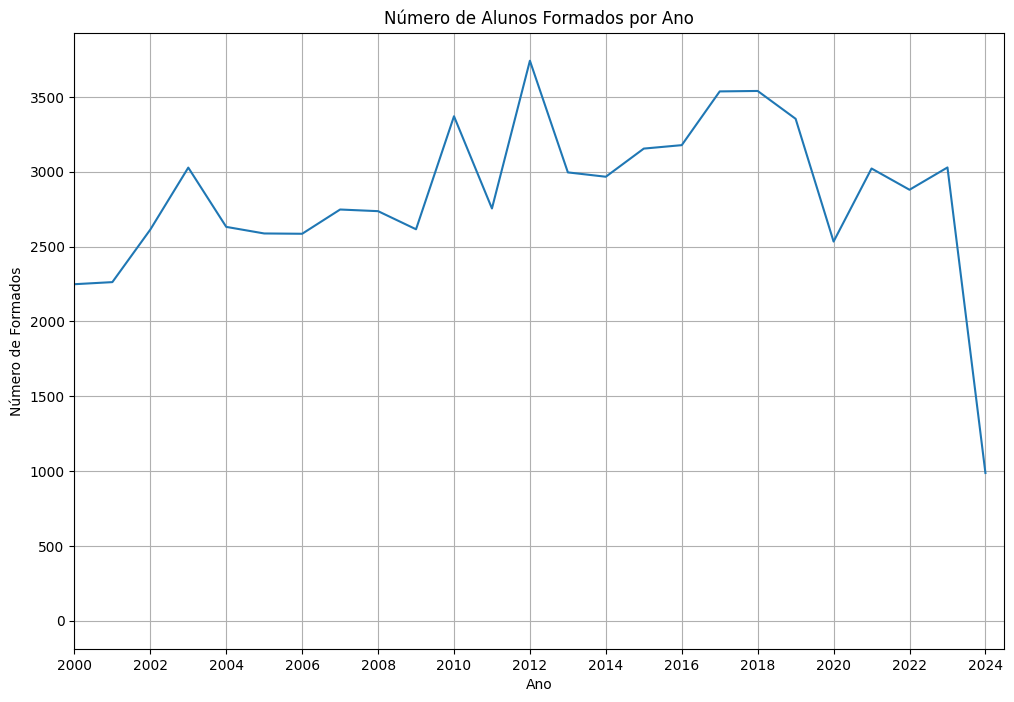

In [130]:
plt.figure(figsize=(12, 8))

anos = df_grad.value_counts("ano_formatura").sort_index().index.values
quantidade = df_grad.value_counts("ano_formatura").sort_index().values

plt.plot(anos, quantidade)

plt.xlabel("Ano")
plt.ylabel("Número de Formados")
plt.title("Número de Alunos Formados por Ano")
plt.xlim(2000, 2024.5)
plt.xticks(range(2000, 2025, 2))
plt.grid()
plt.show()

In [151]:
cursos_ctc = [
    "Engenharia De Materiais [semestral]",  #
    "Arquitetura E Urbanismo",  #
    "Engenharia Sanitária E Ambiental",  #
    "Engenharia De Produção Elétrica",  #
    "Engenharia De Produção - Bacharelado",  # Não listado na pagina de egressos.
    "Sistemas De Informação (noturno)",  #
    "Engenharia Eletrônica",  #
    "Engenharia De Alimentos",  #
    "Ciências Da Computação",
    "Engenharia De Produção Mecânica",  #
    "Engenharia De Controle E Automação",  #
    "Engenharia De Produção Civil",  #
    "Engenharia Elétrica",  #
    "Engenharia De Materiais",  #
    "Engenharia Química",  #
    "Engenharia Civil",  #
    "Engenharia Mecânica",  #
]

cursos_ctc = [curso.lower() for curso in cursos_ctc]

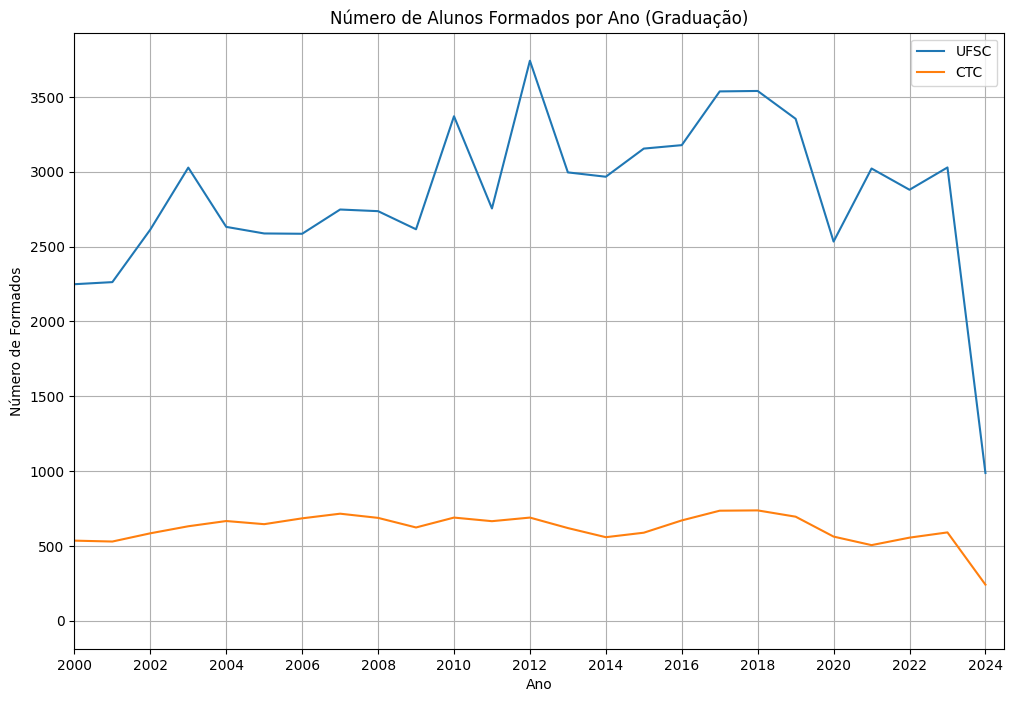

In [157]:
df_ctc = df_grad[df_grad["Nome do Curso"].apply(lambda x: x.lower()).isin(cursos_ctc)]

plt.figure(figsize=(12, 8))

anos = df_grad.value_counts("ano_formatura").sort_index().index.values
quantidade = df_grad.value_counts("ano_formatura").sort_index().values

anos_ctc = df_ctc.value_counts("ano_formatura").sort_index().index.values
quantidade_ctc = df_ctc.value_counts("ano_formatura").sort_index().values

plt.plot(anos, quantidade, label="UFSC")
plt.plot(anos_ctc, quantidade_ctc, label="CTC")

plt.xlabel("Ano")
plt.ylabel("Número de Formados")
plt.title("Número de Alunos Formados por Ano (Graduação)")
plt.xlim(2000, 2024.5)
plt.xticks(range(2000, 2025, 2))
plt.grid()
plt.legend()
plt.show()

In [159]:
len(df_ctc[df_ctc["ano_formatura"] >= 2000])

15422

In [160]:
len(df_ctc)

23500